## Deploy Models for Inference

1. [Introduction](#Introduction)
2. [Prerequisites](#Prerequisites)
3. [Setup](#Setup)
4. [Deploy pretrained model to SageMaker Endpoint](#Deploy-pretrained-model-to-SageMaker-Endpoint)
    1. [Model Config](#Model-Config)
    2. [Option 1: Serverless Inference](#Option-1:-Serverless-Inference)
        1. [Serverless Inference Deploy Config](#Serverless-Inference-Deploy-Config)
        2. [Serverless Inference Deployment](#Serverless-Inference-Deployment)
    3. [Option 2: Real-time Inference](#Option-2:-Real-time-Inference)
        1. [Real-time Inference Deployment](#Real-time-Inference-Deployment)
5. [Run Inference on Deployed Endpoint](#Run-Inference-on-Deployed-Endpoint)
    1. [Create Predictor from Inference Endpoint](#Create-Predictor-from-Inference-Endpoint)
    2. [Get trained Classes Info](#Get-trained-Classes-Info)
    3. [Download sample test images from S3 for inference](#Download-sample-test-images-from-S3-for-inference)
    4. [Get Predictions from local images](#Get-Predictions-from-local-images)
6. [Clean Up](#Clean-Up)

# Introduction
After you build and train your models, you can deploy them to get predictions. SageMaker supports multiple deployment types for customers to choose from, based on the requirements, like Real-time inference, Serverless inference, Asynchronous inference, and Batch transform. To learn more about deploying models for inference using SageMaker refer [here](https://docs.aws.amazon.com/sagemaker/latest/dg/deploy-model.html).  

** Note: This Notebook was tested on Data Science Kernel for SageMaker Studio**

## Prerequisites

To run this notebook, you can simply execute each cell in order. To understand what's happening, you'll need:

- Prepare our model for deployment (either use the model from the previous modules or run the optional-prepare-data-and-model.ipynb notebook to create a new model)
- Familiarity with Python and numpy
- Basic familiarity with AWS S3.
- Basic understanding of AWS Sagemaker.
- Basic familiarity with AWS Command Line Interface (CLI) -- ideally, you should have it set up with credentials to access the AWS account you're running this notebook from.
- SageMaker Studio is preferred for the full UI integration

## Setup

Setting up the environment, load the libraries, and define the parameters for the entire notebook.


In [4]:
import sagemaker
from sagemaker import get_execution_role
import boto3
import botocore
import json

role = get_execution_role()
sess = sagemaker.Session()
region = boto3.Session().region_name

# Feel free to specify different bucket/folders here if you wish.
bucket = sess.default_bucket()
prefix = "BIRD-Sagemaker-Deployment"

TF_FRAMEWORK_VERSION = '2.4.1'
ENDPOINT_INSTANCE_TYPE = 'ml.c5.4xlarge'

## Deploy pretrained model to SageMaker Endpoint

### Model Config

You can use the bird model use created from the previous modules or run the `optional-prepare-data-and-model.ipynb` notebook to create a new model. Update the path to your model below as necessary.

In [5]:
# INPUT REQUIRED - Please enter the S3 URI of the model artifact
# eg: s3://sagemaker-us-east-1-xxxxxxxx/BIRD-Sagemaker-Deployment/BIRD-Sagemaker-Deployment-2022-07-27-03-33-54-592/output/model.tar.gz
bird_model_path = '<S3 LOCATION OF YOUR MODEL ARTIFACTS>'

## Choose the deployment option for Inference

Run either Option 1 or Option 2

## Option 1: Serverless Inference

Amazon SageMaker Serverless Inference is a new inference option that enables you to easily deploy machine learning models for inference without having to configure or manage the underlying infrastructure. Simply select the serverless option when deploying your machine learning model, and Amazon SageMaker automatically provisions, scales, and turns off compute capacity based on the volume of inference requests. With SageMaker Serverless Inference, you pay only for the duration of running the inference code and the amount of data processed, not for idle time. For more information on how Serverless Inference works visit [here](https://docs.aws.amazon.com/sagemaker/latest/dg/serverless-endpoints.html). 

### Serverless Inference Deploy Config

This object specifies configuration related to serverless endpoint. Use this configuration when trying to create serverless endpoint and make serverless inference

Initialize a ServerlessInferenceConfig object for serverless inference configuration.


In [6]:
import sagemaker.serverless as Serverless

serverless_inf_config = Serverless.ServerlessInferenceConfig(memory_size_in_mb=4096, max_concurrency=5)

### Serverless Inference Deployment

Deploy the Model to a serverless endpoint and return a Predictor object to make serverless inference

In [7]:
from sagemaker.tensorflow import TensorFlowModel

model = TensorFlowModel(
    model_data=bird_model_path, 
    role=role,
    framework_version=TF_FRAMEWORK_VERSION)


predictor = model.deploy(serverless_inference_config=serverless_inf_config)
tf_endpoint_name = str(predictor.endpoint_name)
print(f"Endpoint [{predictor.endpoint_name}] deployed")

update_endpoint is a no-op in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


---------!Endpoint [tensorflow-inference-2022-07-27-03-48-42-085] deployed


The endpoint name will be displayed in the previous cell output when it's active and can also be seen under the SageMaker Resources option which is on the left side bar of the Studio as well. You will need it in the next section to create predictor from Inference endpoint

![Active Endpoint](statics/active-sagemaker-endpoints.png)

## Option 2: Real-time Inference

### Real-time Inference Deployment

Real-time inference is ideal for inference workloads where you have real-time, interactive, low latency requirements. You can deploy your model to SageMaker hosting services and get an endpoint that can be used for inference. These endpoints are fully managed and support autoscaling.

Deploy the Model to a real-time endpoint and return a Predictor object to make inference

In [12]:
from sagemaker.tensorflow import TensorFlowModel

model = TensorFlowModel(
    model_data=bird_model_path,
    role=role,
    framework_version=TF_FRAMEWORK_VERSION)


predictor = model.deploy(initial_instance_count=1, instance_type=ENDPOINT_INSTANCE_TYPE)
tf_endpoint_name = str(predictor.endpoint_name)
print(f"Endpoint [{predictor.endpoint_name}] deployed")

update_endpoint is a no-op in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


-----!Endpoint [tensorflow-inference-2022-07-27-03-57-28-041] deployed


The endpoint name will be displayed in the previous cell output when it's active and can also be seen under the SageMaker Resources option which is on the left side bar of the Studio as well. You will need it in the next section to create predictor from Inference endpoint

![Active Endpoint](statics/active-sagemaker-endpoints.png)

## Run Inference on Deployed Endpoint

### Create Predictor from Inference Endpoint

After the deployment is complete in the above step, capture the endpoint name from SageMaker console and input below in the Predictor config. We could have reused the predictor from above step that is returned after deploy is complete, but this section shows how you can create a predictor from an existing endpoint for inference.

In [13]:
from sagemaker import Predictor
from sagemaker.serializers import IdentitySerializer
from sagemaker.deserializers import JSONDeserializer

#Update the below variable with your endpoint name from previous cell output
#tf_endpoint_name='<SAGEMAKER DEPLOYED ENDPOINT NAME>'
tf_endpoint_name = 'tensorflow-inference-2022-07-27-03-57-28-041'

serializer = IdentitySerializer(content_type="application/x-image")
deserializer = JSONDeserializer(accept='application/json')

predictor = Predictor(endpoint_name=tf_endpoint_name,serializer = serializer,deserializer = deserializer )

### Get trained Classes Info

In [14]:
import cv_utils

classes_file = f"s3://{bucket}/{prefix}/full/data/classes.txt"
classes = [13, 17, 35, 36, 47, 68, 73, 87]

possible_classes= cv_utils.get_classes_as_list(classes_file,classes)

possible_classes

['013.Bobolink',
 '017.Cardinal',
 '035.Purple_Finch',
 '036.Northern_Flicker',
 '047.American_Goldfinch',
 '068.Ruby_throated_Hummingbird',
 '073.Blue_Jay',
 '087.Mallard']

### Download sample test images from S3 for inference

This cell downloads a random number of images (specified by value of 'n') from 'test' data set and use them for running inferences using our model.

In [15]:
sample_images = cv_utils.get_n_random_images(bucket,prefix=f'{prefix}/outputs/test',n=2)

local_paths = cv_utils.download_images_locally(bucket,sample_images)
print(local_paths)

['./inference-test-data/Bobolink_0044_9990.jpg', './inference-test-data/American_Goldfinch_0043_31993.jpg']


### Get Predictions from local images

./inference-test-data/Bobolink_0044_9990.jpg


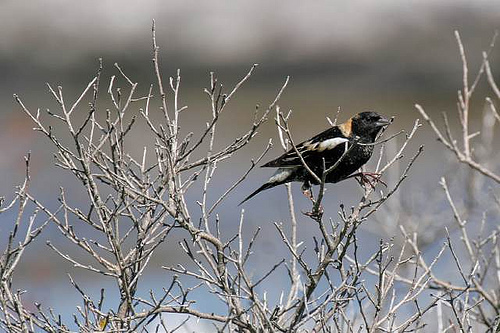

Class: 013.Bobolink, confidence: 1.00
./inference-test-data/American_Goldfinch_0043_31993.jpg


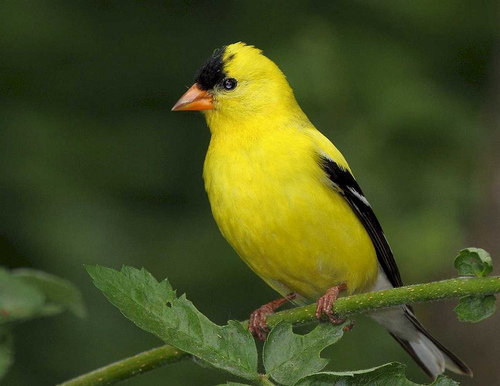

Class: 047.American_Goldfinch, confidence: 1.00


In [16]:
for inputfile in local_paths:
    print(inputfile)
    cv_utils.predict_bird_from_file(inputfile,predictor,possible_classes)

## Clean Up